Test whether convergence improves by iteratively adding more data.

In [41]:
from functools import partial

from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Run the following before any XLA modules such as JAX:
import chex

chex.set_n_cpu_devices(4)

import sys
sys.path.append("../src")

# Import the remaining JAX related 
from gabenet.mcmc import sample_markov_chain
from gabenet.nets import MultinomialDirichletBelieve
from gabenet.utils import freeze_trainable_states, holdout_split, perplexity

import haiku as hk
import jax
from jax import random
import jax.numpy as jnp

In [42]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
X_train, X_test = train_test_split(X, test_size=0.2, random_state=0)

X_train = X_train[:40]

In [43]:
# Pseudo-random number generator sequence.
key_seq = hk.PRNGSequence(42)

m_samples, n_features = X_train.shape

@hk.transform_with_state
def kernel(X=X_train, training=True):
    """Advance the Markov chain by one step."""
    n_hidden_units = (10, )
    model = MultinomialDirichletBelieve(n_hidden_units, n_features)
    # Do one Gibbs sampling step.
    model(X)

In [44]:
n_chains = jax.device_count()

params, states = sample_markov_chain(
    next(key_seq), 
    kernel=kernel, 
    n_samples=(10240 + 500)*4, 
    n_burnin_steps=0, 
    n_chains=n_chains,
)

_ = states['multinomial_dirichlet_believe/~/multinomial_layer']['phi'].block_until_ready()

 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75.
 76. 77. 78. 79.]


After training the model, we can inspect what the model has learned. Note that, instead of a single point estimate of the parameters, we've obtained a distribution. To visualise the parameters, we take for simplicity the median. Let's take a look at $\bm{\Phi}^{(1)}$, the weights of the first layer.

In [45]:
import arviz as az
from jax.tree_util import tree_map
from scipy.stats import entropy

def make_idata(states):
    entr_theta = entropy(
        states["multinomial_dirichlet_believe/~/cap_layer"]["theta"], axis=-1
    )
    r_entr = entropy(states["multinomial_dirichlet_believe/~/cap_layer"]["r"], axis=-1)

    return az.convert_to_dataset(
        {
            "c": states["multinomial_dirichlet_believe/~/cap_layer"]["c"],
            "s[theta(1)]": entr_theta,
            "s[r]": r_entr,
        }
    )

In [46]:
n_burnins = [10, 40, 160, 640, 1280, 2560, 5120, 10240]
traces = {}
idatas = {}
for i in n_burnins:
    trace_subset = tree_map(lambda x: x[:,i:i+500], states)
    idatas[i] = make_idata(trace_subset)
    traces[i] = trace_subset

In [47]:
from collections import defaultdict

r_hats = defaultdict(list)
for i in n_burnins:
    r_i = az.summary(idatas[i])['r_hat']
    for name in ['c', 's[r]']:
        r_hats[name].append(r_i[name])

Text(0, 0.5, 'r-hat')

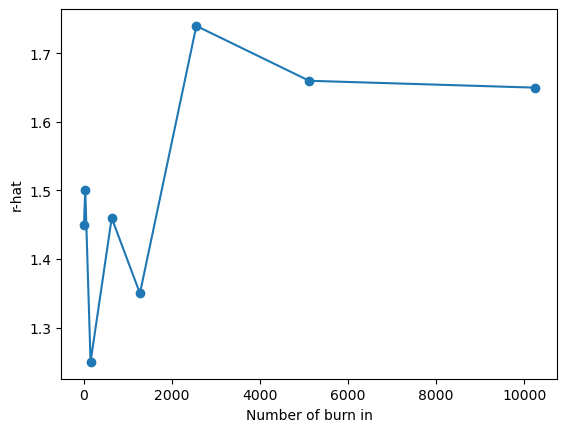

In [48]:
# This is based on 40 examples.
plt.plot(n_burnins, r_hats['c'], '-o')
plt.xlabel('Number of burn in')
plt.ylabel('r-hat')

Text(0, 0.5, 'r-hat')

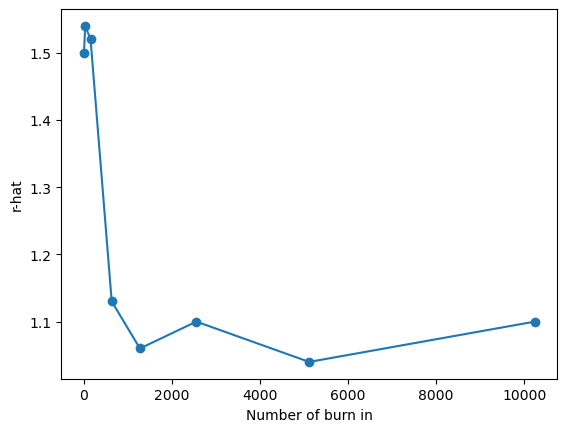

In [39]:
# This is based on 20 examples.
plt.plot(n_burnins, r_hats['c'], '-o')
plt.xlabel('Number of burn in')
plt.ylabel('r-hat')

Text(0, 0.5, 'r-hat')

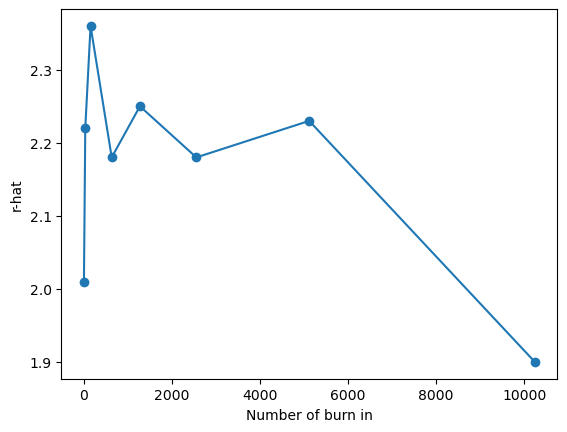

In [49]:
# This is based on 40 examples.
plt.plot(n_burnins, r_hats['s[r]'], '-o')
plt.xlabel('Number of burn in')
plt.ylabel('r-hat')

Text(0, 0.5, 'r-hat')

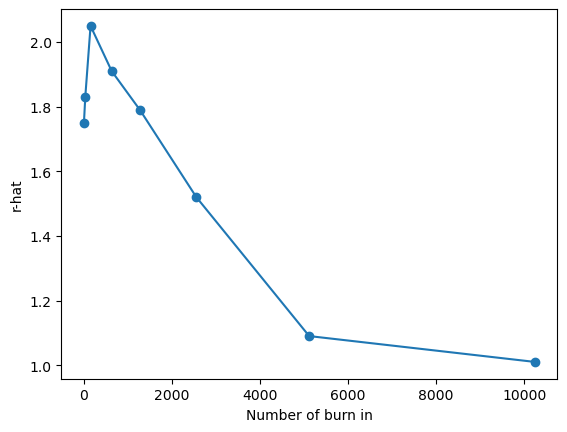

In [40]:
# This is based on 20 examples.
plt.plot(n_burnins, r_hats['s[r]'], '-o')
plt.xlabel('Number of burn in')
plt.ylabel('r-hat')

# Partial training on subset (dilution series).

In [29]:
X_A, _ = holdout_split(next(key_seq), X_train, test_size=0.5)

In [30]:
kernel_a = hk.TransformedWithState(
    init=partial(kernel.init, X=X_A), apply=partial(kernel.apply, X=X_A)
)
params, states = sample_markov_chain(
    next(key_seq), 
    kernel=kernel_a, 
    n_samples=4 + 4, 
    n_burnin_steps=0, 
    n_chains=n_chains,
)
state = tree_map(lambda x: x[:, -1], states)

In [32]:
params, states = sample_markov_chain(
    next(key_seq), 
    kernel=kernel, 
    n_samples=4 + 4, 
    n_burnin_steps=0, 
    params=params,
    initial_state=state,
)


<Figure size 640x480 with 0 Axes>

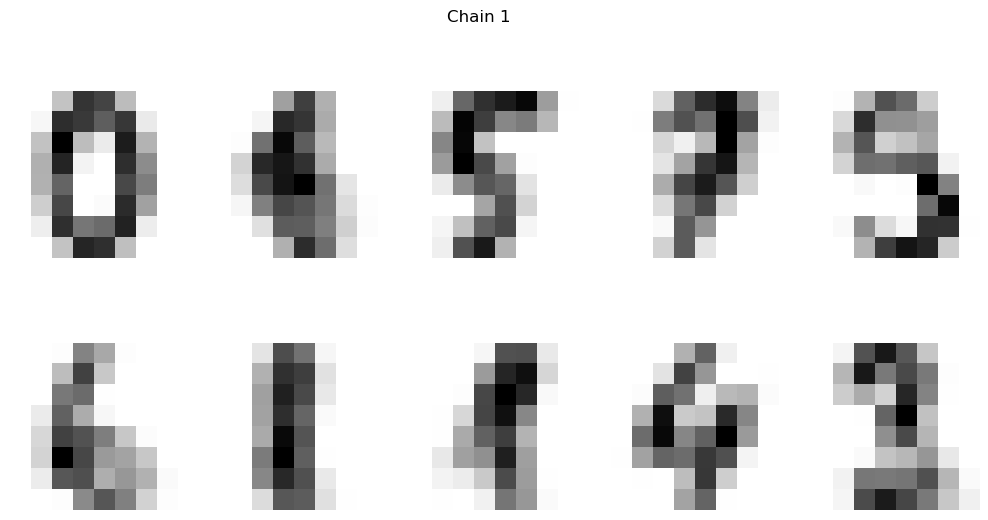

<Figure size 640x480 with 0 Axes>

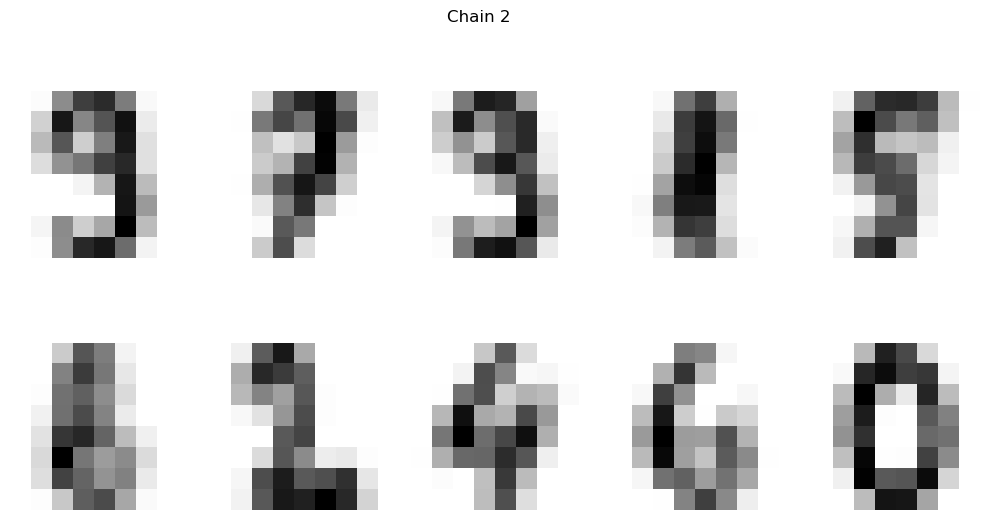

In [5]:
# Aggregate posterior samples to visualise.
phi_1st_layer = np.median(states['multinomial_dirichlet_believe/~/multinomial_layer']['phi'], axis=[1])

for i in range(n_chains):  # For each Markov chain.
    plt.figure()
    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(12.5, 6))
    plt.suptitle(f'Chain {i+1}')
    # Plot the weights of all 10 hidden states.
    for ax, phi in zip(axes.flatten(), phi_1st_layer[i]):
        ax.set_axis_off()
        image = phi.reshape(8, 8)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")